In [6]:
pip install joblib numpy pandas matplotlib scikit-learn seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.16.3-cp314-cp314-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 39.6 MB/s eta 0:00:00a 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached scipy-1.16.3-cp314-cp314-macosx_14_0_arm64.whl (20.9 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
#!/usr/bin/env python3
"""
feature_importance.py

VC – Dec 5

Tasks:
- Load best logistic regression model from /models/logistic_model.pkl
- Extract coefficients
- Rank features by absolute coefficient value
- Save top 10 features to /results/top_features.csv
- Create feature importance bar chart
- Save to /results/figures/feature_importance.png
"""

from pathlib import Path
import argparse

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: Format 'json' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

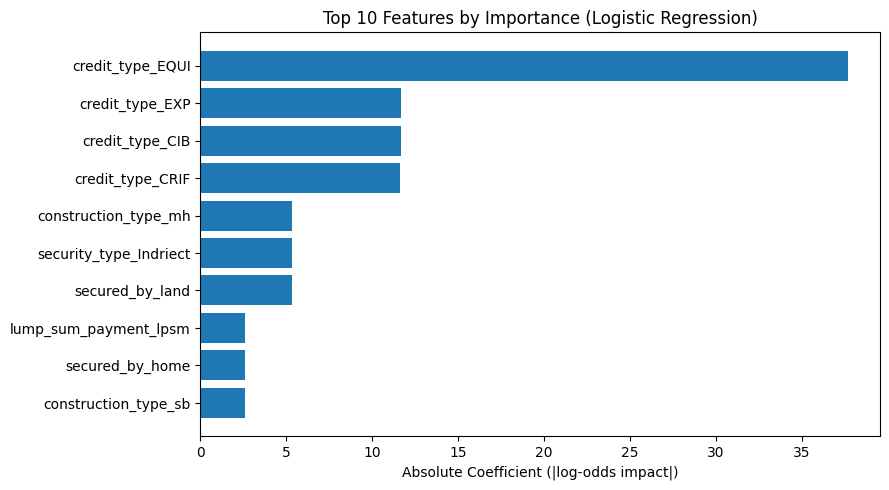

In [9]:

def load_model(model_path: Path):
    """Load trained model (could be plain LogisticRegression or a Pipeline)."""
    model = joblib.load(model_path)

    # If it's a sklearn Pipeline, extract the final estimator
    try:
        from sklearn.pipeline import Pipeline
        if isinstance(model, Pipeline):
            # try to get classifier by name first
            if "clf" in model.named_steps:
                return model.named_steps["clf"], model
            # otherwise assume last step is the classifier
            return model.steps[-1][1], model
    except Exception:
        # sklearn might not be installed when just reading docs, ignore
        pass

    # Otherwise assume model itself is the estimator
    return model, model


def get_feature_names(estimator, train_path: Path, target_col: str):
    """
    Try to infer feature names.

    Priority:
    1) estimator.feature_names_in_ (sklearn >=1.0)
    2) columns from train.csv dropping target_col
    """
    if hasattr(estimator, "feature_names_in_"):
        return list(estimator.feature_names_in_)

    # Fallback: infer from train.csv
    df_sample = pd.read_csv(train_path, nrows=5)
    if target_col not in df_sample.columns:
        raise ValueError(
            f"target_col='{target_col}' not found in train.csv. "
            f"Columns: {list(df_sample.columns)}"
        )

    feature_cols = [c for c in df_sample.columns if c != target_col]
    if not feature_cols:
        raise ValueError("No feature columns found after dropping target_col.")
    return feature_cols


def extract_coefficients(estimator, n_features: int) -> np.ndarray:
    """
    Extract coefficient vector from binary logistic regression model.

    We assume:
    - estimator.coef_ exists
    - estimator.coef_ shape is (1, n_features) or (n_classes, n_features)
    """
    if not hasattr(estimator, "coef_"):
        raise TypeError(
            "Loaded estimator has no 'coef_' attribute. "
            "Make sure you're using LogisticRegression as the final model."
        )

    coefs = estimator.coef_
    coefs = np.array(coefs)

    # For binary classification, sklearn uses shape (1, n_features)
    if coefs.ndim == 2 and coefs.shape[0] == 1:
        coefs = coefs.ravel()
    elif coefs.ndim == 2 and coefs.shape[0] > 1:
        # Multiclass: we can average across classes, or pick class 1.
        # Here we simply take the coef for the "positive" class (index 1) if exists,
        # else fall back to mean across rows.
        if coefs.shape[0] > 1:
            coefs = coefs[1]
        else:
            coefs = coefs.mean(axis=0)
    else:
        raise ValueError(f"Unexpected shape for coef_: {coefs.shape}")

    if coefs.shape[0] != n_features:
        raise ValueError(
            f"Number of coefficients ({coefs.shape[0]}) does not match "
            f"number of features ({n_features})."
        )

    return coefs


def build_importance_df(feature_names, coefs: np.ndarray) -> pd.DataFrame:
    """Create dataframe with feature, coefficient, abs(|coef|), and sign."""
    df = pd.DataFrame(
        {
            "feature": feature_names,
            "coefficient": coefs,
        }
    )
    df["abs_coefficient"] = df["coefficient"].abs()
    df["effect"] = np.where(df["coefficient"] > 0, "increases_risk", "decreases_risk")
    df_sorted = df.sort_values("abs_coefficient", ascending=False).reset_index(drop=True)
    return df_sorted


def save_top_features(df_sorted: pd.DataFrame, out_csv: Path, top_k: int = 10):
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    df_sorted.head(top_k).to_csv(out_csv, index=False)


def plot_feature_importance(df_sorted: pd.DataFrame, out_png: Path, top_k: int = 10):
    """Horizontal bar chart of |coefficient| for top_k features."""
    out_png.parent.mkdir(parents=True, exist_ok=True)

    top = df_sorted.head(top_k).copy()
    # Reverse so most important is at top of plot
    top = top.iloc[::-1]

    plt.figure(figsize=(9, 5))
    plt.barh(top["feature"], top["abs_coefficient"])
    plt.xlabel("Absolute Coefficient (|log-odds impact|)")
    plt.title(f"Top {top_k} Features by Importance (Logistic Regression)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()


def main():
    parser = argparse.ArgumentParser(description="Compute logistic feature importance.")
    parser.add_argument(
        "--model_path",
        type=str,
        default="/Users/mac/Downloads/MMA/RSM8421/credit-risk-counterfactual/models/logistic_model.pkl",
        help="Path to trained logistic regression model.",
    )
    parser.add_argument(
        "--train_path",
        type=str,
        default="/Users/mac/Downloads/MMA/RSM8421/credit-risk-counterfactualdata/train.csv",
        help="Path to training data CSV (for feature names).",
    )
    parser.add_argument(
        "--target_col",
        type=str,
        default="loan_default",  # ⚠️ CHANGE THIS TO YOUR ACTUAL TARGET COLUMN
        help="Name of target column to drop from train.csv.",
    )
    parser.add_argument(
        "--top_k",
        type=int,
        default=10,
        help="Number of top features to output.",
    )
    parser.add_argument(
        "--top_features_csv",
        type=str,
        default="/Users/mac/Downloads/MMA/RSM8421/credit-risk-counterfactual/results/top_features.csv",
        help="Where to save top features CSV.",
    )
    parser.add_argument(
        "--fig_path",
        type=str,
        default="/Users/mac/Downloads/MMA/RSM8421/credit-risk-counterfactualresults/figures/feature_importance.png",
        help="Where to save feature importance figure.",
    )

    args = parser.parse_args()

    model_path = Path(args.model_path)
    train_path = Path(args.train_path)
    out_csv = Path(args.top_features_csv)
    out_fig = Path(args.fig_path)

    # 1) Load model + final estimator
    estimator, raw_model = load_model(model_path)

    # 2) Get feature names
    feature_names = get_feature_names(estimator, train_path, args.target_col)

    # 3) Extract coefficients
    coefs = extract_coefficients(estimator, n_features=len(feature_names))

    # 4) Build importance dataframe
    df_sorted = build_importance_df(feature_names, coefs)

    # 5) Save outputs
    save_top_features(df_sorted, out_csv, top_k=args.top_k)
    plot_feature_importance(df_sorted, out_fig, top_k=args.top_k)

    print(f"[OK] Saved top {args.top_k} features to {out_csv}")
    print(f"[OK] Saved feature importance plot to {out_fig}")


if __name__ == "__main__":
    main()
